In [183]:
import sqlite3
import pandas as pd
from functions_sandbox import cleaner
import seaborn as sns
import matplotlib.pyplot as plt

location = r"D:\IT_projects\Turing_Colledge\Modul2\Sprint1\project\mental_health.sqlite"
con = sqlite3.connect(location)

Table No. 1

In [162]:
query1 = """
SELECT *
FROM Survey;
"""
pd.read_sql_query(query1, con)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


Table No. 2

In [163]:
query2 = """
SELECT *
FROM Question;
"""
pd.read_sql_query(query2, con)

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


Table No. 3

In [164]:
query3 = """
SELECT *
FROM Answer;
"""
pd.read_sql_query(query3, con)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


All tables joined

In [ ]:
query4 = """
SELECT Answer.AnswerText, Answer.SurveyID, Answer.UserID,
        Answer.QuestionID, Question.questiontext QuestionText,
        Survey.Description
FROM Answer
JOIN Question
ON Answer.QuestionID = Question.QuestionID
JOIN Survey
ON Answer.SurveyID = Survey.SurveyID
"""
pd.read_sql_query(query4, con)

## Data cleaning

In [155]:
joined_df = pd.read_sql_query(query4, con)
joined_df = cleaner(joined_df, info=False)
joined_df

,answertext,surveyid,userid,questionid,questiontext,description
0,37,2014,1,1,What is your age?,mental health survey for 2014
1,44,2014,2,1,What is your age?,mental health survey for 2014
2,32,2014,3,1,What is your age?,mental health survey for 2014
3,31,2014,4,1,What is your age?,mental health survey for 2014
4,31,2014,5,1,What is your age?,mental health survey for 2014
...,...,...,...,...,...,...
236893,Other,2016,2689,117,Which of the following best describes your wor...,mental health survey for 2016
236894,Support,2016,2690,117,Which of the following best describes your wor...,mental health survey for 2016
236895,Back-end Developer,2016,2691,117,Which of the following best describes your wor...,mental health survey for 2016
236896,DevOps/SysAdmin,2016,2692,117,Which of the following best describes your wor...,mental health survey for 2016


Check for the unique amount of numbers in questionid column.

In [ ]:
qid = len(joined_df["questionid"].unique()) #105 uniques
uid = len(joined_df["userid"].unique()) #4218 uniques
sid = len(joined_df["surveyid"].unique()) #5 uniques

After the given result 105, we must to check, which numbers  
of questions are excluded or deleted from table.

In [ ]:
expected_numbers = list(range(1, 118))
numbers = sorted(joined_df["questionid"].unique())
excluded_numbers = set(expected_numbers) - set(numbers)
print(f"Excluded numbers: {sorted(excluded_numbers)}",
      f"\nThere are {len(excluded_numbers)} excluded numbers")

With the simple calculation we find, that there are  
13 excluded numbers of questionid column in a joined table.

## EDA (Exploratory Data Analysis)

### Participants age analysis

Before analysing age, check of participants number  
has been performed

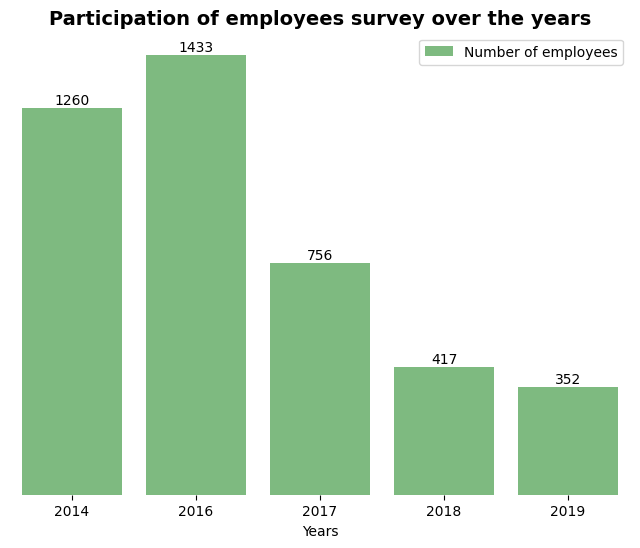

In [278]:
query = """
SELECT SurveyID Years, COUNT(DISTINCT(UserID)) Employees_No
FROM Answer
GROUP BY Years
ORDER BY Years;
"""
employees = pd.read_sql_query(query, con)
#SurveyID, Employees_No
plt.figure(figsize=(8, 6))

splot = sns.barplot(
    data=employees, 
    x="Years", 
    y="Employees_No", 
    label="Number of employees",
    color="#74c476",
    width=0.8
    )

for container in splot.containers:
    splot.bar_label(container)
splot.set_yticks([])
splot.set_ylabel(None)
splot.set_frame_on(False)
splot.set_title(
    "Participation of employees survey over the years",
    size=14,
    fontweight="bold",
    ha="center"
    )

plt.show()

It can be seen, that over the years, participation  
in surveys of employees tend to decreased starting with 2016.

Table with age, gender and years has been created  
where gender answers had to be fixed due to  
letter case sensitivity or unsatisfactory answer.

In [281]:
query = """
SELECT UserID, SurveyID Years,
MAX(CASE WHEN QuestionID = 1 THEN AnswerText END) AS Age,
MAX(CASE WHEN QuestionID = 2 THEN AnswerText END) AS Gender
FROM Answer
WHERE QuestionID IN (1, 2)
GROUP BY UserID
"""
genders_age = pd.read_sql_query(query, con)

genders_age["Gender"] = genders_age["Gender"].str.lower()
genders_age["Gender"] = genders_age["Gender"].apply(lambda x: "other" if x not in ("female", "male") else x)
genders_age = genders_age[genders_age["Gender"] != "other"]
# genders_age["Gender"].value_counts()

,UserID,Years,Age,Gender
0,1,2014,37,female
1,2,2014,44,male
2,3,2014,32,male
3,4,2014,31,male
4,5,2014,31,male
...,...,...,...,...
4213,4214,2019,27,male
4214,4215,2019,48,male
4215,4216,2019,50,male
4216,4217,2019,30,female


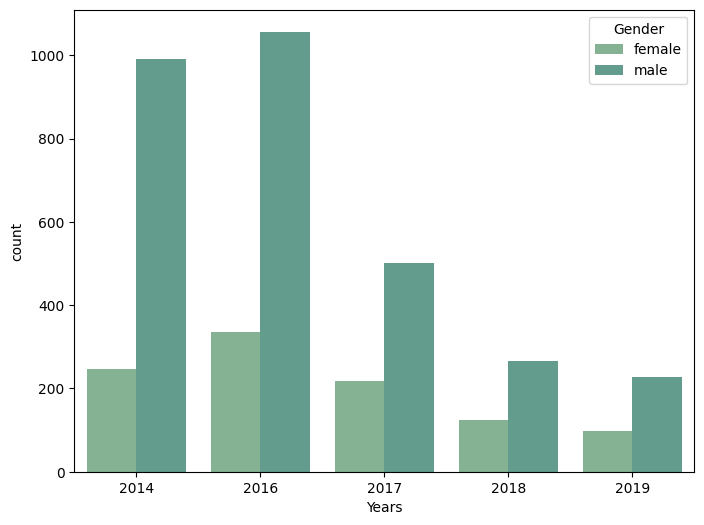

In [284]:
gender = genders_age.pivot_table(index="Years", columns="Gender", aggfunc="size")

plt.figure(figsize=(8, 6))
splot = sns.countplot(
    data=genders_age,
    x='Years',
    hue="Gender"
)

plt.show()